In [88]:
#Bibliotecas
import polars as pl
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import re
import math

In [89]:
caminho_arquivo = "tratados_3det/proton/proton3.16E15"
def processar_arquivo(nome_arquivo):
    # Listas para armazenar as detecções por tipo de partícula e por detector
    positrons = {"TRIG1": [], "TRIG2": [], "TRIG3": []}
    electrons = {"TRIG1": [], "TRIG2": [], "TRIG3": []}
    muons_plus = {"TRIG1": [], "TRIG2": [], "TRIG3": []}
    muons_minus = {"TRIG1": [], "TRIG2": [], "TRIG3": []}
    times = {"TRIG1": [], "TRIG2": [], "TRIG3": []}
    theta_real = []
    phi_real = []

    # Listas para totais por detector
    total_por_detector = {"TRIG1": [], "TRIG2": [], "TRIG3": []}

    # Listas para somas de elétrons+pósitrons e múons+/-
    soma_electrons_positrons = {"TRIG1": [], "TRIG2": [], "TRIG3": []}
    soma_muons_plus_minus = {"TRIG1": [], "TRIG2": [], "TRIG3": []}

    # Abrir e ler o arquivo
    with open(nome_arquivo, 'r') as arquivo:
        for linha in arquivo:
            linha = linha.strip()

            if "EVTH" in linha:
                #partes = linha.split()
                partes = linha.split("EVTH")[-1].split()
                theta = float(partes[-2])
                phi = float(partes[-1])
                theta_real.append(theta)
                phi_real.append(phi)            

            # Processar apenas linhas que começam com TRIG
            if linha.startswith("TRIG"):
                partes = linha.split()
                detector = partes[0]  # TRIG1, TRIG2, TRIG3

                # Valores das partículas
                pos = int(partes[1])  # Pósitrons
                ele = int(partes[2])  # Elétrons
                mu_p = int(partes[3])  # Múons+
                mu_m = int(partes[4])  # Múons-
                t = float(partes[5]) # Menor tempo de disparo em ns

                # Adicionar os valores às listas correspondentes
                positrons[detector].append(pos)
                electrons[detector].append(ele)
                muons_plus[detector].append(mu_p)
                muons_minus[detector].append(mu_m)
                times[detector].append(t)

                # Calcular totais
                total = pos + ele + mu_p + mu_m
                total_por_detector[detector].append(total)

                # Calcular somas
                soma_electrons_positrons[detector].append(pos + ele)
                soma_muons_plus_minus[detector].append(mu_p + mu_m)

    # Retornar os dados processados
    return {
        "positrons": positrons,
        "electrons": electrons,
        "muons_plus": muons_plus,
        "muons_minus": muons_minus,
        "tempos": times,
        "total_por_detector": total_por_detector,
        "soma_electrons_positrons": soma_electrons_positrons,
        "soma_muons_plus_minus": soma_muons_plus_minus,
        "theta_real": theta_real,
        "phi_real":phi_real
    }

# Função principal
def main():
    
    dados = processar_arquivo(caminho_arquivo)

    # Alguns testes
    print("ângulos:", dados["theta_real"])
    print("Tempos no TRIG1:", dados["tempos"]["TRIG1"])
    print("Detecções de pósitrons no TRIG1:", dados["positrons"]["TRIG1"])
    print("Total de partículas no TRIG2:", dados["total_por_detector"]["TRIG2"])
    print("Soma de elétrons e pósitrons no TRIG3:", dados["soma_electrons_positrons"]["TRIG3"])

    return dados

# Executar o programa
if __name__ == "__main__":
    dados_processados = main()


ângulos: [45.309, 30.681, 56.95, 54.159, 40.22, 48.196, 53.05, 27.831, 7.887, 18.605, 29.563, 2.635, 28.475, 50.38, 11.3, 39.999, 34.234, 37.884, 30.003, 19.706, 32.919, 52.263, 34.592, 30.085, 55.017, 41.046, 29.837, 29.401, 27.833, 52.104, 38.427, 48.936, 41.406, 33.275, 37.782, 49.23, 12.437, 27.568, 49.077, 20.18, 38.647, 18.434, 6.369, 48.759, 32.446, 39.094, 28.221, 25.956, 17.692, 8.738, 28.244, 38.246, 38.611, 38.498, 34.676, 59.376, 29.449, 21.747, 53.175, 16.825, 52.785, 24.633, 48.609, 35.477, 44.016, 39.86, 55.852, 34.934, 42.993, 58.61, 26.228, 59.441, 47.682, 7.848, 35.062, 14.402, 45.474, 47.774, 30.293, 7.237, 38.108, 42.819, 49.379, 17.529, 51.0, 50.813, 15.403, 59.224, 27.072, 28.671, 32.088, 55.278, 54.968, 23.604, 19.603, 40.365, 33.931, 22.29, 35.839, 50.031, 41.397, 32.659, 56.398, 42.23, 54.963, 29.832, 26.211, 57.266, 10.659, 49.583, 47.94, 9.033, 34.85, 45.102, 25.658, 27.494, 1.706, 29.19, 47.821, 59.046, 41.932, 44.872, 24.105, 12.003, 29.122, 17.093, 38.096,

In [90]:
def formatar_string(s):

    nome_arquivo = s.split('/')[-1]
   
    match = re.match(r'([a-zA-Z]+)([0-9]+(?:\.[0-9]+)?[Ee][0-9]+)', nome_arquivo)

    if match:
        
        palavra = match.group(1).capitalize()
        numero = match.group(2)

        return f'{palavra} {numero}'
    else:
        return nome_arquivo

name = formatar_string(caminho_arquivo)
name

'Proton 3.16E15'

In [91]:
# Posição dos tanques
x1 = [0, 800/np.sqrt(3)]
x2 = [-400, -400/np.sqrt(3)]
x3 = [400, -400/np.sqrt(3)]

# Distância dos tanques em relação ao centro
r1 = (x1[0]**2+x1[1]**2)**0.5
r2 = (x2[0]**2+x2[1]**2)**0.5
r3 = (x3[0]**2+x3[1]**2)**0.5


# Total de partículas em cada tanque
trig1_total = dados_processados['total_por_detector']['TRIG1']
trig2_total = dados_processados['total_por_detector']['TRIG2']
trig3_total = dados_processados['total_por_detector']['TRIG3']

print(trig1_total,'\n',
      trig2_total,'\n',
      trig3_total)

[9, 41, 0, 0, 282, 3, 0, 766, 267, 975, 32, 194, 386, 2, 215, 6, 27, 17, 107, 252, 219, 1, 46, 59, 1, 9, 126, 139, 36, 1, 22, 18, 44, 22, 29, 2, 136, 117, 6, 748, 241, 74, 249, 57, 59, 6, 69, 134, 235, 359, 46, 6, 36, 31, 72, 0, 100, 178, 0, 299, 0, 75, 0, 53, 2, 19, 0, 45, 6, 0, 51, 0, 8, 187, 37, 100, 3, 7, 32, 153, 55, 3, 49, 120, 13, 0, 141, 0, 504, 21, 107, 0, 1, 60, 116, 23, 37, 224, 79, 25, 14, 35, 0, 7, 3, 68, 300, 0, 140, 0, 16, 123, 28, 5, 90, 129, 655, 118, 0, 0, 19, 2, 275, 77, 120, 337, 13, 352, 129, 96, 182, 147, 3, 82, 208, 253, 16, 47, 524, 0, 45, 32, 1185, 7, 1, 14, 101, 122, 190, 71, 14, 25, 1, 191, 68, 448, 12, 40, 40, 248, 35, 149, 2, 184, 137, 57, 147, 0, 6, 0, 28, 1, 1, 1, 3, 39, 3, 0, 0, 64, 2, 0, 17, 8, 2, 0, 29, 0, 10, 143, 93, 174, 0, 752, 47, 0, 0, 6, 893, 0, 15, 12, 23, 60, 0, 2, 313, 14, 0, 20, 374, 0, 104, 0, 1, 1020, 150, 0, 893, 0, 40, 197, 8, 28, 81, 13, 118, 1, 19, 184, 23, 23, 120, 76, 60, 0, 99, 443, 52, 179, 37, 17, 402, 207, 32, 137, 6, 3, 8, 134, 

In [92]:
# Triangulação

triangulacao = [
    (a, b, c) for a, b, c in zip(trig1_total, trig2_total, trig3_total) if a != 0 and b != 0 and c != 0
]

trig1, trig2, trig3 = zip(*triangulacao) if triangulacao else ([], [], [])


print(trig1,'\n',
      trig2,'\n',
      trig3)

(9, 41, 282, 766, 267, 975, 32, 194, 386, 2, 215, 6, 27, 17, 107, 252, 219, 1, 46, 59, 9, 126, 139, 36, 1, 22, 18, 44, 22, 29, 2, 136, 117, 6, 748, 241, 74, 249, 57, 59, 6, 69, 134, 235, 359, 46, 6, 36, 31, 72, 100, 178, 299, 75, 53, 2, 19, 45, 6, 51, 8, 187, 37, 100, 3, 7, 32, 153, 55, 3, 49, 120, 13, 141, 504, 21, 107, 1, 60, 116, 23, 37, 224, 79, 25, 14, 35, 7, 3, 68, 300, 140, 16, 123, 28, 5, 90, 129, 655, 118, 19, 2, 275, 77, 120, 337, 13, 352, 129, 96, 182, 147, 3, 82, 208, 253, 16, 47, 524, 45, 32, 1185, 7, 14, 101, 122, 190, 71, 14, 25, 1, 191, 68, 448, 12, 40, 40, 248, 35, 149, 184, 137, 57, 147, 28, 1, 1, 39, 3, 64, 17, 8, 2, 29, 10, 143, 93, 174, 752, 47, 6, 893, 15, 12, 23, 60, 2, 313, 14, 20, 374, 104, 1020, 150, 893, 40, 197, 8, 28, 81, 13, 118, 19, 184, 23, 23, 120, 76, 60, 99, 443, 52, 179, 37, 17, 402, 207, 32, 137, 6, 3, 8, 134, 102, 131, 38, 115, 24, 13, 16, 92, 58, 61, 42, 192, 43, 123, 132, 55, 83, 367, 111, 168, 3, 59, 442, 124, 92, 12, 83, 10, 2, 9, 9, 117, 50, 1

In [93]:
theta_real = dados_processados['theta_real']
phi_real = dados_processados['phi_real']

triangulacao_angulos = [
        (theta, phi) for theta, phi, a, b, c in zip(theta_real, phi_real, trig1_total, trig2_total, trig3_total)
        if a != 0 and b != 0 and c != 0
    ]
    
# Separar os ângulos filtrados
theta_filtrado, phi_filtrado = zip(*triangulacao_angulos) if triangulacao_angulos else ([], [])
    
print("Theta:", theta_filtrado)
print("Phi:", phi_filtrado)

Theta: (45.309, 30.681, 40.22, 27.831, 7.887, 18.605, 29.563, 2.635, 28.475, 50.38, 11.3, 39.999, 34.234, 37.884, 30.003, 19.706, 32.919, 52.263, 34.592, 30.085, 41.046, 29.837, 29.401, 27.833, 52.104, 38.427, 48.936, 41.406, 33.275, 37.782, 49.23, 12.437, 27.568, 49.077, 20.18, 38.647, 18.434, 6.369, 48.759, 32.446, 39.094, 28.221, 25.956, 17.692, 8.738, 28.244, 38.246, 38.611, 38.498, 34.676, 29.449, 21.747, 16.825, 24.633, 35.477, 44.016, 39.86, 34.934, 42.993, 26.228, 47.682, 7.848, 35.062, 14.402, 45.474, 47.774, 30.293, 7.237, 38.108, 42.819, 49.379, 17.529, 51.0, 15.403, 27.072, 28.671, 32.088, 54.968, 23.604, 19.603, 40.365, 33.931, 22.29, 35.839, 50.031, 41.397, 32.659, 42.23, 54.963, 29.832, 26.211, 10.659, 47.94, 9.033, 34.85, 45.102, 25.658, 27.494, 1.706, 29.19, 41.932, 44.872, 24.105, 12.003, 29.122, 17.093, 38.096, 27.675, 23.03, 31.123, 17.482, 43.503, 47.884, 17.714, 24.893, 32.568, 43.783, 48.165, 6.864, 36.178, 32.88, 5.369, 35.917, 37.286, 19.323, 11.435, 9.99, 26.3

In [94]:
# Tempos originais de cada detector
tempos_trig1 = dados_processados['tempos']['TRIG1']
tempos_trig2 = dados_processados['tempos']['TRIG2']
tempos_trig3 = dados_processados['tempos']['TRIG3']

triangulacao_tempos = [
    (t1, t2, t3) for t1, t2, t3, a, b, c in zip(tempos_trig1, tempos_trig2, tempos_trig3, trig1_total, trig2_total, trig3_total) 
    if a != 0 and b != 0 and c != 0
]

# Separar os tempos filtrados
tempos1, tempos2, tempos3 = zip(*triangulacao_tempos) if triangulacao_tempos else ([], [], [])

print(tempos1, '\n', tempos2, '\n', tempos3)

(122230.0, 68985.2, 40782.6, 52932.7, 102095.0, 31906.7, 138913.0, 93902.4, 38968.9, 88934.6, 82042.2, 203982.0, 95647.6, 110941.0, 124466.0, 53855.4, 85989.4, 120551.0, 103114.0, 72336.3, 87406.7, 78591.1, 62004.8, 126566.0, 103669.0, 216270.0, 185635.0, 148395.0, 131841.0, 74363.7, 119579.0, 153105.0, 68594.3, 92846.7, 43787.1, 57264.5, 73686.3, 97747.4, 119058.0, 74882.2, 96204.9, 65465.8, 67095.4, 58950.3, 151400.0, 96399.5, 81543.4, 74034.5, 86304.2, 76962.5, 152062.0, 67428.6, 54110.6, 129891.0, 63916.4, 121247.0, 96980.4, 151872.0, 112265.0, 158336.0, 80521.0, 77301.6, 122161.0, 103924.0, 65113.3, 76106.1, 80145.4, 118913.0, 74646.7, 130019.0, 66888.0, 108649.0, 75695.0, 63295.7, 57771.3, 161049.0, 100153.0, 140997.0, 80867.3, 126280.0, 77470.8, 111528.0, 106686.0, 59951.4, 222433.0, 155646.0, 65392.8, 104033.0, 81313.9, 93072.2, 70294.6, 101016.0, 139092.0, 108651.0, 118511.0, 212814.0, 103570.0, 51003.9, 61721.2, 65354.9, 122629.0, 110281.0, 45932.0, 121014.0, 75011.9, 87509.7

In [95]:
# Reconstrução da direção de chegada
from scipy.optimize import fsolve
from sympy import symbols, cos, Eq, nsolve
import random
c = 3e8  # Velocidade da luz em m/s
detectores = [
    np.array([0, 8/np.sqrt(3)]),     # TRIG1
    np.array([-4, -4/np.sqrt(3)]), # TRIG2
    np.array([4, -4/np.sqrt(3)])   # TRIG3
]

def reconstruir_direcao(tempos1, tempos2, tempos3):
    # Converter tempos para segundos
    t1 = np.array(tempos1) * 1e-9
    t2 = np.array(tempos2) * 1e-9
    t3 = np.array(tempos3) * 1e-9
    
    # Listas para resultados
    thetas = []
    phis = []
    
    for i in range(len(t1)):
        # Coordenadas e tempos do evento atual
        x = [detectores[0][0], detectores[1][0], detectores[2][0]]
        y = [detectores[0][1], detectores[1][1], detectores[2][1]]
        t = [t1[i], t2[i], t3[i]]
        
        #sigma = 1e-9  # 1 ns 
        #t_flutuado = [ti + np.random.normal(0, sigma) for ti in t]

        #t = t_flutuado

        # Cálculo das somas
        sum_x = sum(x)
        sum_y = sum(y)
        sum_x2 = sum(xi**2 for xi in x)
        sum_y2 = sum(yi**2 for yi in y)
        sum_xy = sum(x[i]*y[i] for i in range(3))
        sum_xt = sum(x[i]*t[i] for i in range(3))
        sum_yt = sum(y[i]*t[i] for i in range(3))
        sum_t = sum(t)
        
        # Montagem do sistema linear
        A = (sum_x**2/3 - sum_x2)
        B = (sum_x*sum_y/3 - sum_xy)
        C = c * (sum_xt - sum_x*sum_t/3)
        D = (sum_y**2/3 - sum_y2)
        E = c * (sum_yt - sum_y*sum_t/3)
        
        # Solução do sistema
        try:
            # A*cos_alpha + B*cos_beta = C
            # B*cos_alpha + D*cos_beta = E

            #cos_alpha = (C-(B*(E-(B*C/A))/(D-B**2)))/A
            #cos_beta = (E-(B*C/A))/(D-B**2)

            #def equations(vars, A, B, C, D, E):
            #    alpha, beta = vars
            #    eq1 = A * np.cos(alpha) + B * np.cos(beta) - C
            #   eq2 = B * np.cos(alpha) + D * np.cos(beta) - E
            #    return [eq1, eq2]
            
            #solution = fsolve(equations, [0,0], args= (A,B,C,D,E))
            #alpha, beta = solution
            #print(f"A = {A}, B = {B}, C = {C}, D = {D}, E = {E}")
            # Sympy
            #alpha, beta = symbols('alpha, beta')
            
            #eq1 = (A * cos(alpha) + B * cos(beta) - C)
            #eq2 = (B * cos(alpha) + D * cos(beta) - E)

           
            #alpha, beta = symbols('alpha, beta')
            #solution = nsolve([((A * cos(alpha) + B * cos(beta) - C)), ((B * cos(alpha) + D * cos(beta) - E))], [alpha, beta], [0.5, 0.5])

            #alpha = float(solution[0])
            #beta = float(solution[1])

            # Resolver sistema linear
            det = A * D - B**2
            if det == 0:
                thetas.append(np.nan)
                phis.append(np.nan)
                continue
        
            cos_alpha = (D * C - B * E) / det
            cos_beta = (A * E - B * C) / det
        
            # Normalizar cossenos diretores
            norm = np.sqrt(cos_alpha**2 + cos_beta**2)
            if norm > 1:
                cos_alpha /= norm
                cos_beta /= norm
        
            # Calcular ângulos
            cos_theta = np.sqrt(max(1 - cos_alpha**2 - cos_beta**2, 0))
            theta = np.arccos(cos_theta)
            phi = np.arctan2(cos_beta, cos_alpha) 
            thetas.append(np.degrees(theta)) 
            
            
            #cos_alpha = np.cos(alpha)
            #cos_beta = np.cos(beta)
            # Cálculo de theta e phi
            
            #soma_quadrados = cos_alpha**2 + cos_beta**2
            #if soma_quadrados > 1:
            #    # Normalizar para manter a relação física
            #    fator = 1 / np.sqrt(soma_quadrados)
            #    cos_alpha *= fator
            #    cos_beta *= fator
            #
            ## Cálculo seguro de cos_theta
            #arg_raiz = max(1 - cos_alpha**2 - cos_beta**2, 0)  
            #cos_theta = np.sqrt(arg_raiz)
#
            ##cos_theta = np.sqrt(1 - cos_alpha**2 - cos_beta**2)
            #theta = np.arccos(cos_theta)
            #
            ##sin_theta = np.sqrt(cos_alpha**2 + cos_beta**2)
            #phi = np.arctan2(cos_beta, cos_alpha) 
            ##phi = np.arccos(cos_alpha/np.sin(theta))
            #
            #thetas.append(np.degrees(theta))
            def normalize_angle(degrees):
                return (degrees + 180) % 360 - 180
            if (t3[i] < t2[i] and t1[i]):
                phis.append(normalize_angle(np.degrees(phi + np.pi)))
            elif (t2[i] < t3[i] and t1[i]):
                phis.append(normalize_angle(np.degrees(phi - np.pi)))
            else:
                phis.append(normalize_angle(np.degrees(phi)))
            
        except ZeroDivisionError:
            thetas.append(np.nan)
            phis.append(np.nan)
    
    return thetas, phis

# Uso com os dados filtrados
#theta_graus, phi_graus = reconstruir_direcao(tempos1, tempos2, tempos3, sigma= 1e-9)
theta_graus, phi_graus = reconstruir_direcao(tempos1, tempos2, tempos3)

# Resultados
print("Theta (zenite):", theta_graus)
print("Phi (azimute):", phi_graus)

Theta (zenite): [np.float64(48.698682787285705), np.float64(30.584180542934764), np.float64(39.93011629862007), np.float64(27.742829362430168), np.float64(8.626926558653889), np.float64(18.59845610427416), np.float64(29.958633075034243), np.float64(2.3673776567458127), np.float64(28.610077149893108), np.float64(67.12888129519119), np.float64(11.11197985326466), np.float64(39.63299057707431), np.float64(34.682527212419906), np.float64(38.64548350279379), np.float64(28.828044293400314), np.float64(19.650122560937245), np.float64(32.60322146207225), np.float64(49.34968641491046), np.float64(35.85731553849943), np.float64(30.166773332430946), np.float64(39.56627666782897), np.float64(30.118532306973336), np.float64(29.479544103645445), np.float64(27.142633877543357), np.float64(49.023923123625856), np.float64(39.851520345987005), np.float64(50.00296202133622), np.float64(42.5619875651408), np.float64(32.8583089677335), np.float64(36.61553874576953), np.float64(50.33056619887025), np.float6

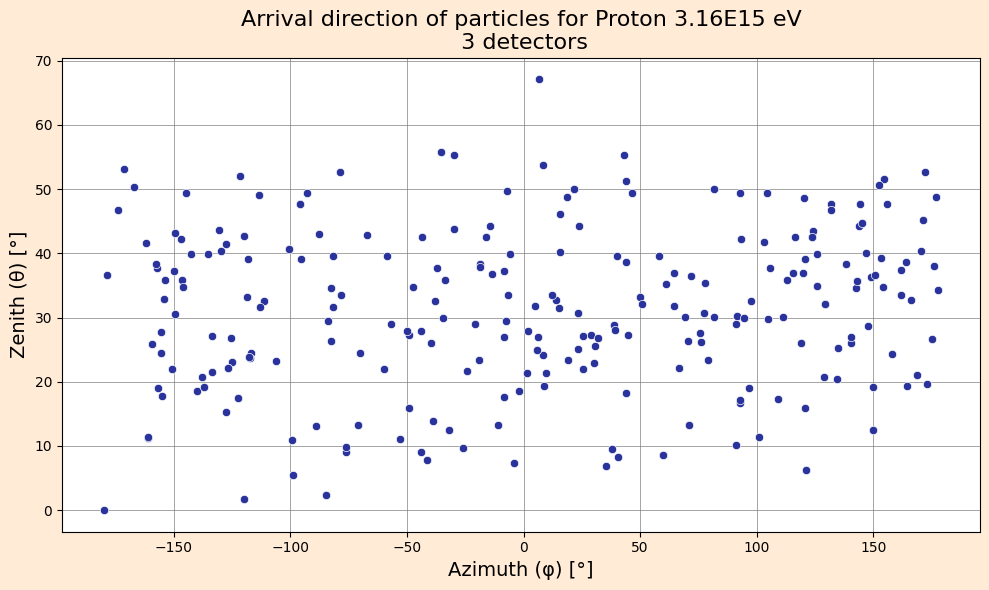

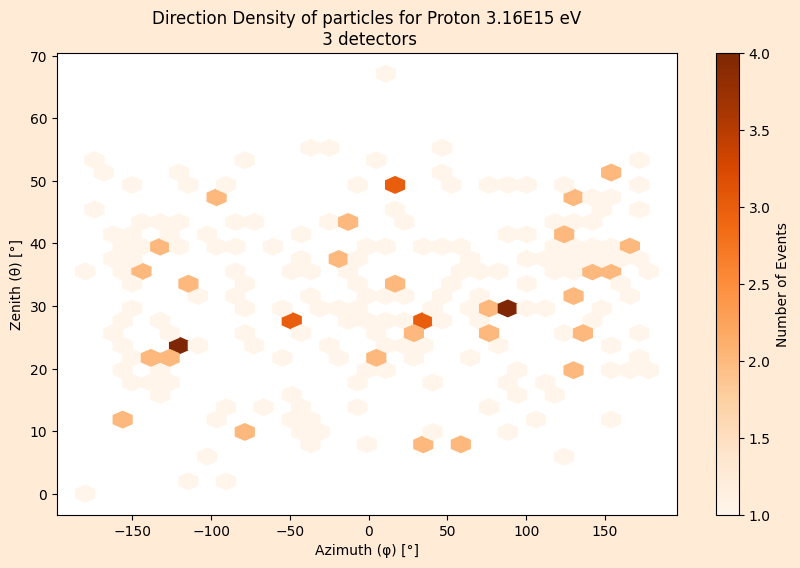

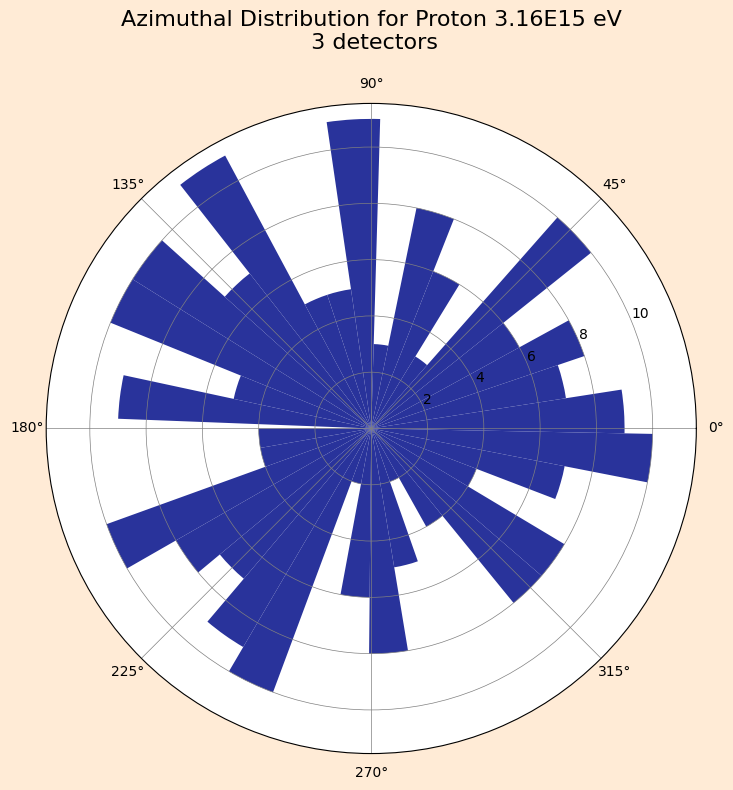

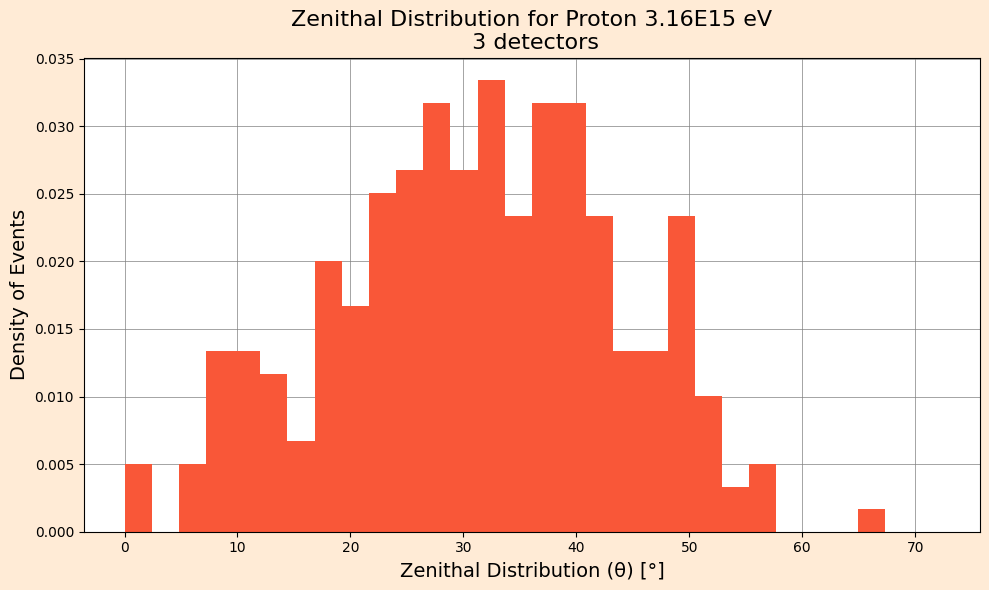

In [96]:
theta = np.array(theta_graus)  # Ângulos zenitais 
phi = np.array(phi_graus)      # Ângulos azimutais 

# Dispersão 2D
fig = plt.figure(figsize=(10, 6), facecolor='#FFEBD6')
ax = fig.add_subplot()
sns.scatterplot(x=phi, y=theta, color='#29339B', ax=ax)
ax.set_title('Arrival direction of particles for ' + str(name) + ' eV\n 3 detectors', fontsize=16)
ax.set_xlabel('Azimuth (φ) [°]', fontsize=14)
ax.set_ylabel('Zenith (θ) [°]', fontsize=14)
ax.set_axisbelow(True)
ax.grid(color='gray', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.savefig('plots/' + name.split(' ')[0].lower() + '/arrival_direction_' + caminho_arquivo.split('/')[-1].split('_')[0] + '_3det.pdf', bbox_inches = 'tight', dpi = 600)
plt.show()

# Histograma 2D
plt.figure(figsize=(10,6), facecolor='#FFEBD6')
plt.hexbin(phi, theta, gridsize=30, cmap='Oranges', mincnt=1)
plt.colorbar(label='Number of Events')
plt.title('Direction Density of particles for ' + str(name) + ' eV\n 3 detectors')
plt.xlabel('Azimuth (φ) [°]')
plt.ylabel('Zenith (θ) [°]')
plt.savefig('plots/' + name.split(' ')[0].lower() + '/density_direction_' + caminho_arquivo.split('/')[-1].split('_')[0] + '_3det.pdf', bbox_inches = 'tight', dpi = 600)
plt.show()

# Rosca Azimutal
fig = plt.figure(figsize=(8, 8), facecolor='#FFEBD6')
ax = fig.add_subplot(111, polar=True)
theta_rad = np.radians(phi)
ax.hist(theta_rad, bins=36, color='#29339B')
ax.set_theta_zero_location('E')
ax.set_theta_direction(1)
ax.set_title('Azimuthal Distribution for ' + str(name) + ' eV\n 3 detectors', fontsize=16, pad=20)
ax.grid(color='gray', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.savefig('plots/' + name.split(' ')[0].lower() + '/azimuthal_' + caminho_arquivo.split('/')[-1].split('_')[0] + '_3det.pdf', bbox_inches = 'tight', dpi = 600)
plt.show()

# Distribuição Zenital
fig = plt.figure(figsize=(10, 6), facecolor='#FFEBD6')
ax = fig.add_subplot()
ax.hist(theta, bins=30, range=(0,max(theta + 5)), density=True, color='#F95738')
ax.set_title('Zenithal Distribution for ' + str(name) + ' eV\n 3 detectors', fontsize=16)
ax.set_xlabel('Zenithal Distribution (θ) [°]', fontsize=14)
ax.set_ylabel('Density of Events', fontsize=14)
ax.set_axisbelow(True)
ax.grid(color='gray', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.savefig('plots/' + name.split(' ')[0].lower() + '/zenithal_' + caminho_arquivo.split('/')[-1].split('_')[0] + '_3det.pdf', bbox_inches = 'tight', dpi = 600)
plt.show()

<Figure size 1200x600 with 0 Axes>

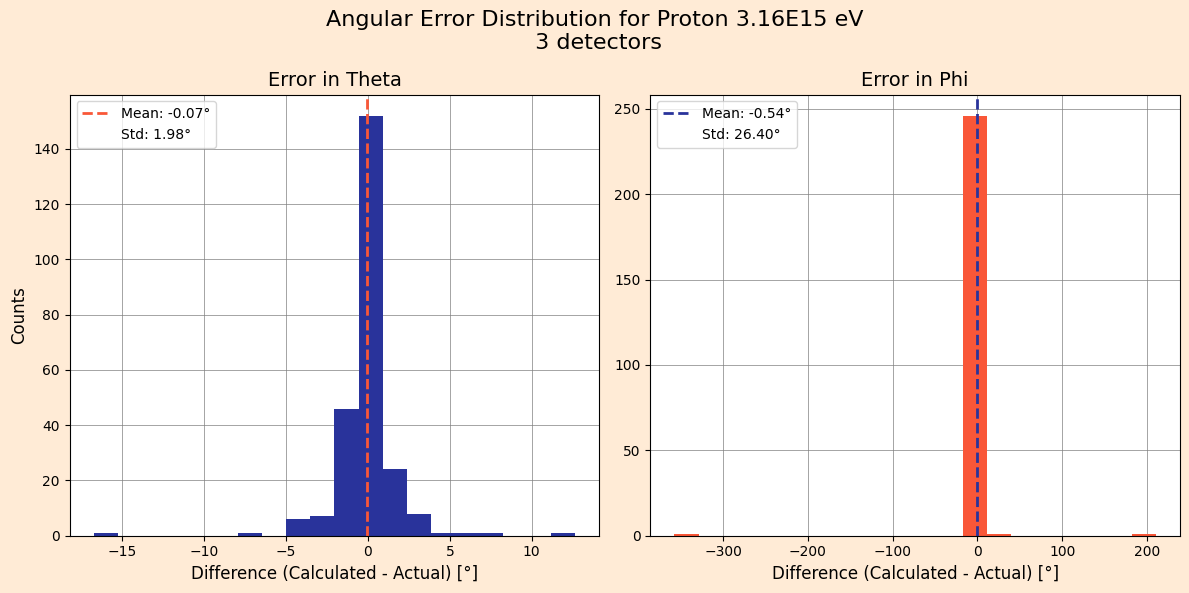

In [97]:
dif_theta = np.array(theta_filtrado) - np.array(theta_graus)
dif_phi = np.array(phi_filtrado) - np.array(phi_graus)

plt.figure(figsize=(12, 6))

fig = plt.figure(figsize=(12, 6), facecolor='#FFEBD6')
fig.suptitle('Angular Error Distribution for ' + str(name) + ' eV\n 3 detectors', fontsize=16)

# Theta
ax1 = fig.add_subplot(121)
ax1.hist(dif_theta, bins=20, color='#29339B')
#ax1.axvline(np.mean(dif_theta), color='k', linestyle='dashed', linewidth=1)
ax1.set_title('Error in Theta', fontsize=14)
ax1.set_xlabel('Difference (Calculated - Actual) [°]', fontsize=12)
ax1.set_ylabel('Counts', fontsize=12)
ax1.set_axisbelow(True)
ax1.grid(color='gray', linestyle='-', linewidth=0.5)
#ax1.text(0.65, 0.9, f'Média: {np.mean(dif_theta):.2f}°\nStd: {np.std(dif_theta):.2f}°', 
#        transform=ax1.transAxes, fontsize=10)
ax1.axvline(np.mean(dif_theta), color='#F95738', linestyle='dashed', linewidth=2, label=f'Mean: {np.mean(dif_theta):.2f}°')
ax1.plot([], [], ' ', label=f'Std: {np.std(dif_theta):.2f}°')
ax1.legend(loc='upper left', fontsize=10)
# Phi
ax2 = fig.add_subplot(122)
ax2.hist(dif_phi, bins=20, color='#F95738')
#ax2.axvline(np.mean(dif_phi), color='k', linestyle='dashed', linewidth=1)
ax2.set_title('Error in Phi', fontsize=14)
ax2.set_xlabel('Difference (Calculated - Actual) [°]', fontsize=12)
ax2.set_axisbelow(True)
ax2.grid(color='gray', linestyle='-', linewidth=0.5)
#ax2.text(0.65, 0.9, f'Média: {np.mean(dif_phi):.2f}°\nStd: {np.std(dif_phi):.2f}°', 
#        transform=ax2.transAxes, fontsize=10)
ax2.axvline(np.mean(dif_phi), color='#29339B', linestyle='dashed', linewidth=2, label=f'Mean: {np.mean(dif_phi):.2f}°')
ax2.plot([], [], ' ', label=f'Std: {np.std(dif_phi):.2f}°')
ax2.legend(loc='upper left', fontsize=10)

plt.tight_layout()
plt.savefig('plots/' + name.split(' ')[0].lower() + '/error_angles_' + caminho_arquivo.split('/')[-1].split('_')[0] + '_3det.pdf', bbox_inches = 'tight', dpi = 600)
plt.show()

In [98]:
x_b = []
y_b = []

for i in range(len(trig1)):
        numerator = (trig1[i]*x1[0]+trig2[i]*x2[0]+trig3[i]*x3[0])
        demoninator = (trig1[i]+trig2[i]+trig3[i])
        numerator1 = (trig1[i]*x1[1]+trig2[i]*x2[1]+trig3[i]*x3[1])

        if demoninator == 0:
                x_b.append(0)
                y_b.append(0)
        else:
                x_b.append(numerator/demoninator)
                y_b.append(numerator1/demoninator)


In [99]:
data = {
    'x_b':x_b,
    'y_b':y_b,
    'trig1':trig1,
    'trig2':trig2,
    'trig3':trig3
}

df = pl.DataFrame(data, strict=False)

df = df.with_columns(
    [
        ((df['x_b']**2+df['y_b']**2)**0.5).alias('r_b'),
        (pl.col('trig1')/(math.pi*65**2)).alias('rho1'),
        (pl.col('trig2')/(math.pi*65**2)).alias('rho2'),
        (pl.col('trig3')/(math.pi*65**2)).alias('rho3')
    ]
)

df = df.with_columns(
    [
        (((x1[0]-df['x_b'])**2 + (x1[1]-df['y_b'])**2)**0.5).alias('r1_b'),
        (((x2[0]-df['x_b'])**2 + (x2[1]-df['y_b'])**2)**0.5).alias('r2_b'),
        (((x3[0]-df['x_b'])**2 + (x3[1]-df['y_b'])**2)**0.5).alias('r3_b'),
    ]
)

df

x_b,y_b,trig1,trig2,trig3,r_b,rho1,rho2,rho3,r1_b,r2_b,r3_b
f64,f64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64
32.0,18.475209,9,7,9,36.950417,0.000678,0.000527,0.000678,444.558208,498.830633,444.558208
33.057851,3.817192,41,35,45,33.277507,0.003089,0.002637,0.00339,459.254347,492.595262,435.611674
-56.612529,-4.286591,282,351,229,56.774583,0.021246,0.026444,0.017253,469.591812,411.444737,509.771339
-21.035197,-11.188403,766,888,761,23.825613,0.05771,0.066902,0.057333,473.536057,438.069782,474.933099
-6.933333,15.703927,267,248,235,17.166375,0.020116,0.018684,0.017705,446.230155,464.041684,475.844531
…,…,…,…,…,…,…,…,…,…,…,…
-5.655247,-7.534751,593,636,610,9.42095,0.044676,0.047916,0.045957,469.44903,453.230336,463.104884
76.712329,-60.107699,36,41,69,97.456231,0.002712,0.003089,0.005198,527.594697,506.397429,365.648233
66.666667,-115.470054,1,2,3,133.333333,0.000075,0.000151,0.000226,581.186526,480.74017,352.766841


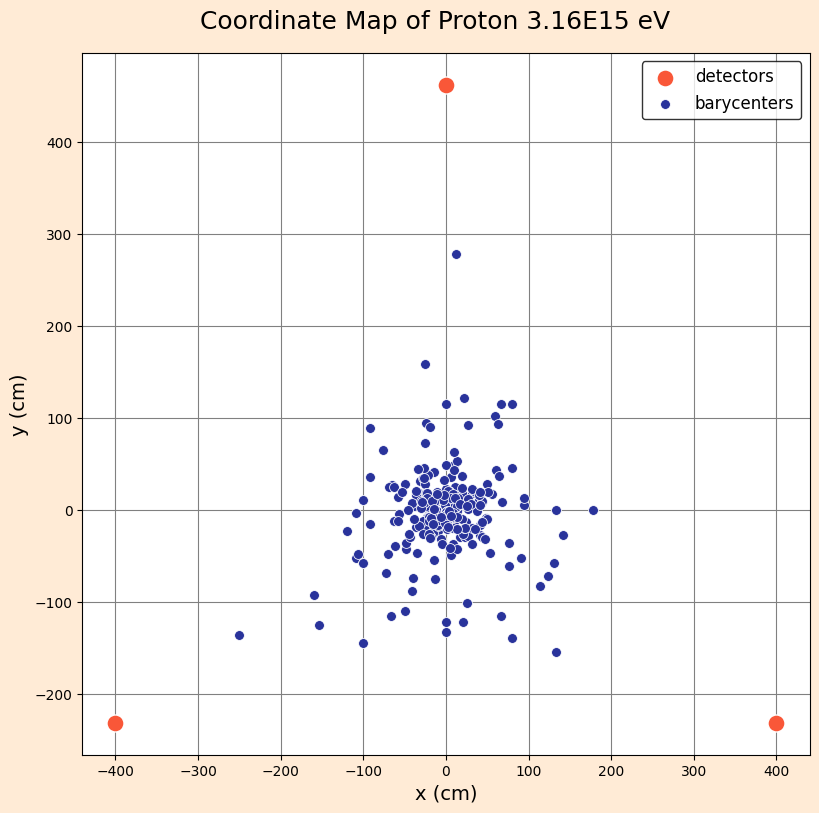

In [100]:
fig, ax = plt.subplots(1, 1, figsize = (8, 8), facecolor = '#FFEBD6')
fig.suptitle('Coordinate Map of ' + str(name) + ' eV', size = 18)
fig.tight_layout()
ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', linestyle='-')
ax.xaxis.grid(color='gray', linestyle='-')

sns.scatterplot(x = [x1[0],x2[0],x3[0]], y = [x1[1],x2[1],x3[1]], ax = ax, color = '#F95738', s = 150)
sns.scatterplot(x = df['x_b'], y = df['y_b'], ax = ax, color = '#29339B',s = 50)

ax.set_xlabel('x (cm)', size = 14)
ax.set_ylabel('y (cm)', size = 14)


ax.legend(['detectors', 'barycenters'], edgecolor = 'black', fontsize = 12, loc = 1)

plt.savefig('plots/' + name.split(' ')[0].lower() +'/map_'+ caminho_arquivo.split('/')[-1] + '_3det.pdf',bbox_inches = 'tight', dpi = 600)

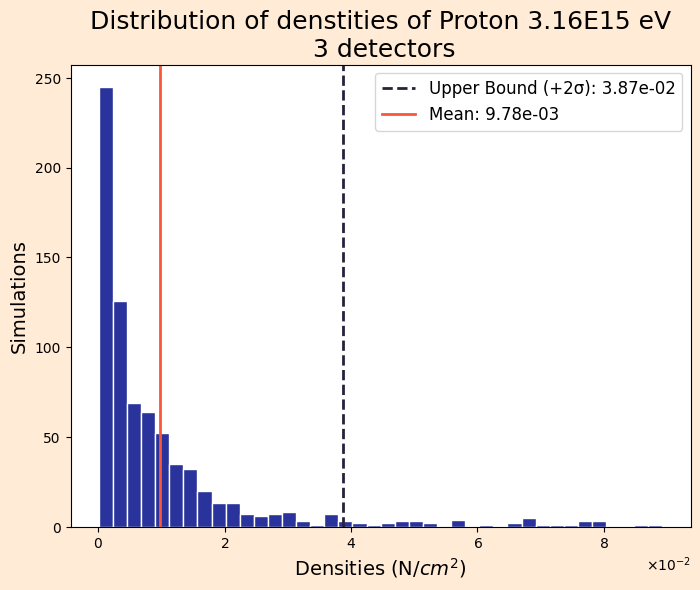

In [101]:
from matplotlib.ticker import ScalarFormatter

values = df.select(['rho1', 'rho2', 'rho3']).to_numpy().flatten()

fig, ax = plt.subplots(figsize=(8, 6), facecolor='#FFEBD6')
plt.hist(values, color='#29339B', bins=40, edgecolor='white')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0), useMathText=True)


plt.ylabel('Simulations')
plt.xlabel('Densities (N/$cm^2$)')  
plt.title('Distribution of denstities of ' + str(name) + ' eV\n 3 detectors', size=18)  

# Calcula a média e o desvio padrão dos dados
mean = values.mean()
std = values.std()

# Determina os limites de 2 sigma
#lower_bound = mean - 2 * std
upper_bound = mean + 2 * std


# Adiciona linhas verticais para os limites de 2 sigma
#ax.axvline(lower_bound, color='#548C2F', linestyle='--', linewidth=2, label=f'Lower Bound (-2σ): {lower_bound:.2f}')
ax.axvline(upper_bound, color='#27213C', linestyle='--', linewidth=2, label=f'Upper Bound (+2σ): {upper_bound:.2e}')
ax.axvline(mean, color='#F95738', linestyle='-', linewidth=2, label=f'Mean: {mean:.2e}')

# Personaliza o eixo e a legenda
ax.set_xlabel('Densities (N/$cm^2$)', size=14)
ax.set_ylabel('Simulations', size=14)
ax.legend(loc='upper right', fontsize=12)

plt.savefig('plots/' + name.split(' ')[0].lower() + '/densities_distribution_' + caminho_arquivo.split('/')[-1] + '.pdf', bbox_inches = 'tight', dpi=600)

In [102]:
# Modelagem NKG
#def model(r, C, s):
#    r0 = 7800
#    return C/(r0**2)*(r/r0)**(s-2)*(1+r/r0)**(s-4.5)

def model(r, C, s, r0=7800):
     return C/(r0**2) * (r/r0)**(s)

parameters = []
uncertainties = []
r_squared_list = []
rmse_list = []

x_cols = ['r1_b', 'r2_b', 'r3_b']  
y_cols = ['rho1', 'rho2', 'rho3']

x = df.select(x_cols).to_numpy()
y = df.select(y_cols).to_numpy()

#for i in range(len(x)):
#    print(f"Linha {i}: x = {x[i]}, y = {y[i]}")

for i in range(len(x)):
    r = x[i]  
    rho = y[i]  
    try:
        popt, pcov = curve_fit(model, r, rho, p0= [1E4, -0.5] , bounds= ([0, -1], [np.inf, 2]))
        perr = np.sqrt(np.diag(pcov))

        # Cálculo das métricas
        y_pred = model(r, *popt)

        # R²
        ss_res = np.sum((rho - y_pred)**2)
        ss_tot = np.sum((rho - np.mean(rho))**2)
        r_sq = 1 - (ss_res/ss_tot) if ss_tot != 0 else np.nan

        # RMSE
        rmse = np.sqrt(np.mean((rho - y_pred)**2))

        parameters.append(popt)
        uncertainties.append(perr)
        r_squared_list.append(r_sq)
        rmse_list.append(rmse)
    except RuntimeError:
        parameters.append([np.nan, np.nan])
        uncertainties.append([np.nan, np.nan])
        r_squared_list.append(np.nan)
        rmse_list.append(np.nan)


parameters_df = pl.DataFrame({
    'C': [p[0] for p in parameters],
    's': [p[1] for p in parameters],
    'C_err': [e[0] for e in uncertainties],
    's_err': [e[1] for e in uncertainties],
    'R_2': r_squared_list,
    'RMSE': rmse_list
})

print(parameters_df)

print("\nEstatísticas dos parâmetros:")
print(f"C: Média = {parameters_df['C'].mean():.2e} ± {parameters_df['C'].std():.2e}")
print(f"s: Média = {parameters_df['s'].mean():.2f} ± {parameters_df['s'].std():.2f}")

shape: (249, 6)
┌───────────────┬───────────┬───────────────┬──────────┬──────────┬──────────┐
│ C             ┆ s         ┆ C_err         ┆ s_err    ┆ R_2      ┆ RMSE     │
│ ---           ┆ ---       ┆ ---           ┆ ---      ┆ ---      ┆ ---      │
│ f64           ┆ f64       ┆ f64           ┆ f64      ┆ f64      ┆ f64      │
╞═══════════════╪═══════════╪═══════════════╪══════════╪══════════╪══════════╡
│ 8886.908394   ┆ -0.515731 ┆ 40406.062406  ┆ 1.606674 ┆ 0.429958 ┆ 0.000054 │
│ 12846.95063   ┆ -0.943712 ┆ 39807.723218  ┆ 1.094257 ┆ 0.712429 ┆ 0.000166 │
│ 78217.737378  ┆ -1.0      ┆ 209323.952222 ┆ 0.941003 ┆ 0.760995 ┆ 0.00184  │
│ 218727.452254 ┆ -0.999829 ┆ 565101.166319 ┆ 0.91301  ┆ 0.769272 ┆ 0.002125 │
│ 67804.540619  ┆ -1.0      ┆ 187970.541274 ┆ 0.980245 ┆ 0.754064 ┆ 0.000491 │
│ …             ┆ …         ┆ …             ┆ …        ┆ …        ┆ …        │
│ 166722.158539 ┆ -0.999315 ┆ 465576.97735  ┆ 0.987796 ┆ 0.752376 ┆ 0.000663 │
│ 13242.487685  ┆ -0.99963  ┆ 26835.

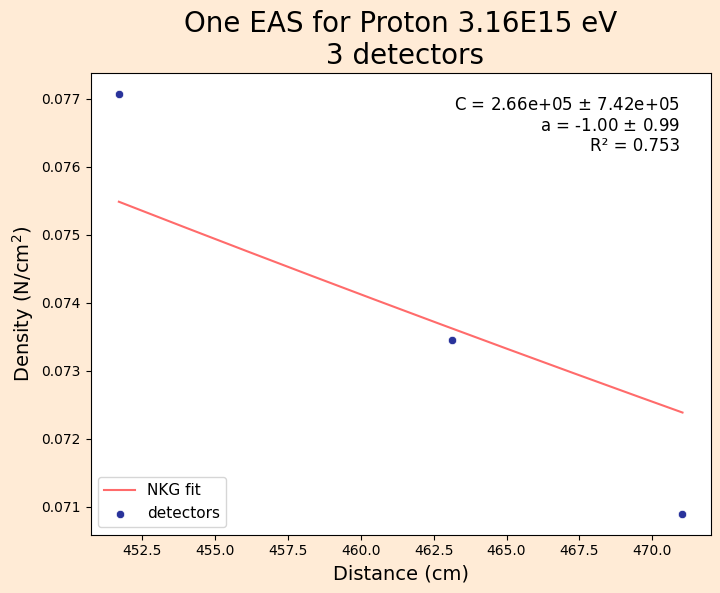

In [103]:
fig, ax = plt.subplots(figsize = (8, 6), facecolor = '#FFEBD6')
plt.title('One EAS for ' + str(name) + ' eV\n 3 detectors', size = 20)
#fig.tight_layout()


#ax.set_title('log C x log E', size = 15)
ax.set_xlabel('Distance (cm)', size = 14)
ax.set_ylabel('Density (N/cm$^2$)', size = 14)
ax.set_facecolor('white')

i = 5

C = parameters_df['C'][i]
s = parameters_df['s'][i]
C_err = parameters_df['C_err'][i]
s_err = parameters_df['s_err'][i]

r_smooth = np.linspace(min(x[i]), max(x[i]), 300)
rho_fit = model(r_smooth, C, s)

sns.lineplot(x=r_smooth, y=rho_fit, color='#FF6B6B', ax=ax, label='NKG fit')

sns.scatterplot(x = x[i], y = y[i], color = '#29339B', ax = ax, label = 'detectors')

textstr = f'C = {C:.2e} $\pm$ {C_err:.2e}\na = {s:.2f} $\pm$ {s_err:.2f}\nR² = {parameters_df["R_2"][i]:.3f}'

ax.text(0.95, 0.95, textstr, transform=ax.transAxes,
        verticalalignment='top', horizontalalignment='right',
        fontsize = 12
        )

ax.legend(
    loc='lower left',
    fontsize=11,
    frameon=True,
    facecolor='white',
)

plt.savefig('plots/' + name.split(' ')[0].lower() + '/one_eas_' + caminho_arquivo.split('/')[-1] + '_3det.pdf', bbox_inches = 'tight', dpi = 600)

Correlação θ-R²: -0.5071
Correlação φ-R²: 0.0317


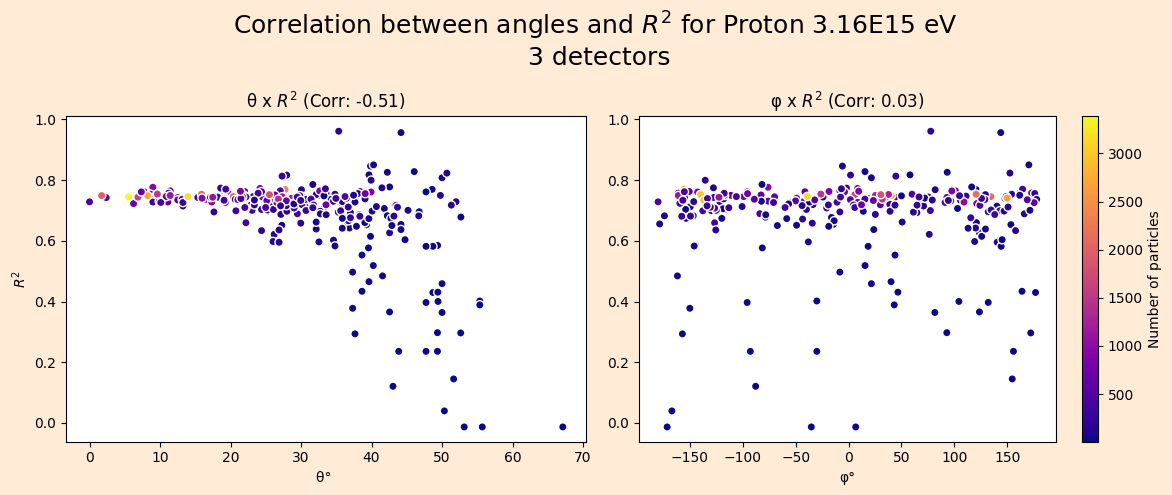

In [104]:
theta = theta_graus
phi = phi_graus
R2 = parameters_df['R_2']
n_particles = []
#for i in range(len(theta_graus)):
#    trigs_i = [row[i] for row in df['trig1','trig2','trig3']]
#    n_particles.append(sum(trigs_i))

n_particles = df.select(
    pl.col("trig1") + pl.col("trig2") + pl.col("trig3")
).to_series().to_list()

combined_df = pl.DataFrame({
    "theta": theta,
    "phi": phi,
    "R2": R2,
    "n_particles": n_particles
})

corr_theta = combined_df.select(pl.corr("theta", "R2")).item()
corr_phi = combined_df.select(pl.corr("phi", "R2")).item()

pd_df = combined_df.to_pandas()
corr_theta = pd_df["theta"].corr(pd_df["R2"])
corr_phi = pd_df["phi"].corr(pd_df["R2"])

print(f"Correlação θ-R²: {corr_theta:.4f}")
print(f"Correlação φ-R²: {corr_phi:.4f}")

fig, ax = plt.subplots(1, 2, figsize=(12, 5), facecolor='#FFEBD6')
fig.suptitle('Correlation between angles and $R^2$ for ' + str(name) + ' eV\n 3 detectors', fontsize=18)

ax[0].scatter(
    combined_df["theta"].to_numpy(),
    combined_df["R2"].to_numpy(),
    c = n_particles,
    cmap = 'plasma',
    #alpha=0.6,
    edgecolor='w'
)
ax[0].set_title(f"θ x $R^2$ (Corr: {corr_theta:.2f})")
ax[0].set_xlabel("θ° ")
ax[0].set_ylabel("$R^2$")

phi_scatter = ax[1].scatter(
    combined_df["phi"].to_numpy(),
    combined_df["R2"].to_numpy(),
    c = n_particles,
    cmap = 'plasma',
    #alpha=0.6,
    edgecolor='w',
    #color='orange'
)
ax[1].set_title(f"φ x $R^2$ (Corr: {corr_phi:.2f})")
ax[1].set_xlabel("φ°")

cbar = fig.colorbar(phi_scatter, ax=ax[1])
cbar.set_label('Number of particles', fontsize=10)

plt.tight_layout()
plt.savefig('plots/' + name.split(' ')[0].lower() + '/corr_angle_' + caminho_arquivo.split('/')[-1] + '_3det.pdf', bbox_inches = 'tight', dpi = 600)


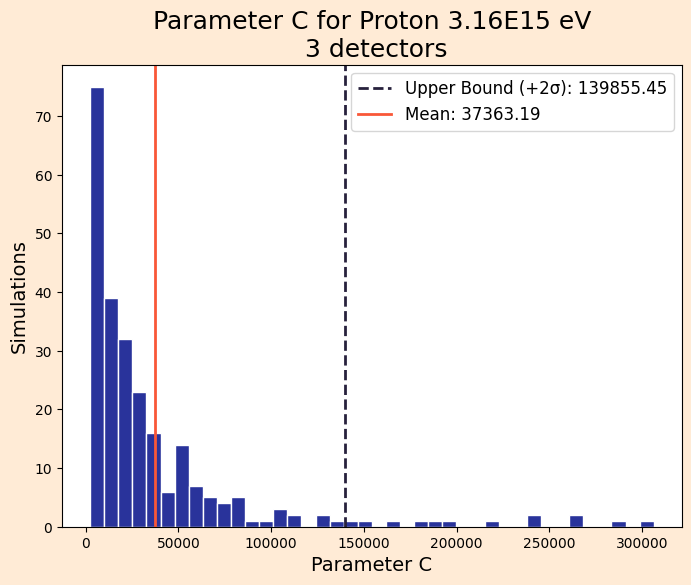

In [105]:
fig, ax = plt.subplots(figsize = (8, 6), facecolor = '#FFEBD6')
plt.hist(parameters_df['C'], color='#29339B', bins= 40, edgecolor = 'white')
plt.ylabel('Simulations')
plt.xlabel('C')
plt.title('Parameter C for ' + str(name) + ' eV\n 3 detectors', size = 18)
#plt.grid(True)

# Calcula a média e o desvio padrão dos dados
mean = parameters_df['C'].mean()
std = parameters_df['C'].std()

# Determina os limites de 2 sigma
#lower_bound = mean - 2 * std
upper_bound = mean + 2 * std


# Adiciona linhas verticais para os limites de 2 sigma
#ax.axvline(lower_bound, color='#548C2F', linestyle='--', linewidth=2, label=f'Lower Bound (-2σ): {lower_bound:.2f}')
ax.axvline(upper_bound, color='#27213C', linestyle='--', linewidth=2, label=f'Upper Bound (+2σ): {upper_bound:.2f}')
ax.axvline(mean, color='#F95738', linestyle='-', linewidth=2, label=f'Mean: {mean:.2f}')

# Personaliza o eixo e a legenda
ax.set_xlabel('Parameter C', size=14)
ax.set_ylabel('Simulations', size=14)
ax.legend(loc='upper right', fontsize=12)

plt.savefig('plots/' + name.split(' ')[0].lower() + '/par_c_' + caminho_arquivo.split('/')[-1] + '_3det.pdf', bbox_inches = 'tight', dpi = 600)

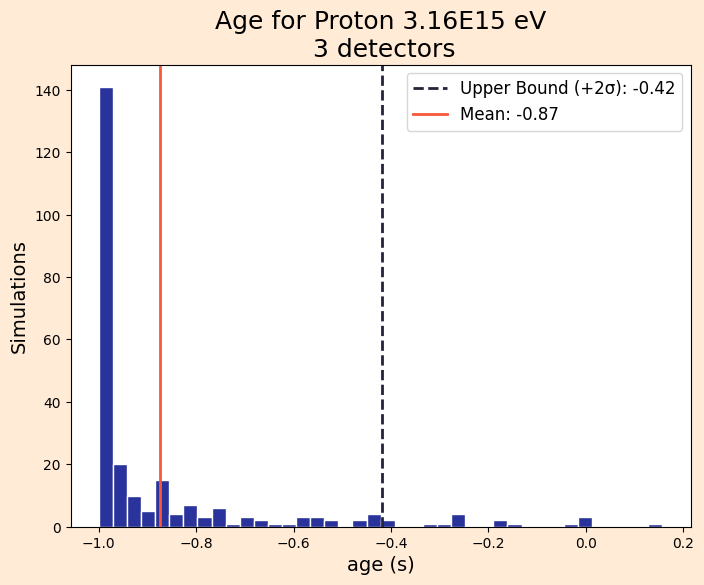

In [106]:
fig, ax = plt.subplots(figsize = (8, 6), facecolor = '#FFEBD6')
plt.hist(parameters_df['s'], color='#29339B', bins= 40, edgecolor = 'white')
plt.ylabel('Simulations')
plt.xlabel('s')
plt.title('Age for ' + str(name) + ' eV\n 3 detectors', size = 18)
#plt.grid(True)

# Calcula a média e o desvio padrão dos dados
mean = parameters_df['s'].mean()
std = parameters_df['s'].std()

# Determina os limites de 2 sigma
#lower_bound = mean - 2 * std
upper_bound = mean + 2 * std


# Adiciona linhas verticais para os limites de 2 sigma
#ax.axvline(lower_bound, color='#548C2F', linestyle='--', linewidth=2, label=f'Lower Bound (-2σ): {lower_bound:.2f}')
ax.axvline(upper_bound, color='#27213C', linestyle='--', linewidth=2, label=f'Upper Bound (+2σ): {upper_bound:.2f}')
ax.axvline(mean, color='#F95738', linestyle='-', linewidth=2, label=f'Mean: {mean:.2f}')

# Personaliza o eixo e a legenda
ax.set_xlabel('age (s)', size=14)
ax.set_ylabel('Simulations', size=14)
ax.legend(loc='upper right', fontsize=12)

plt.savefig('plots/' + name.split(' ')[0].lower() + '/age_' + caminho_arquivo.split('/')[-1] + '_3det.pdf', bbox_inches = 'tight', dpi=600)

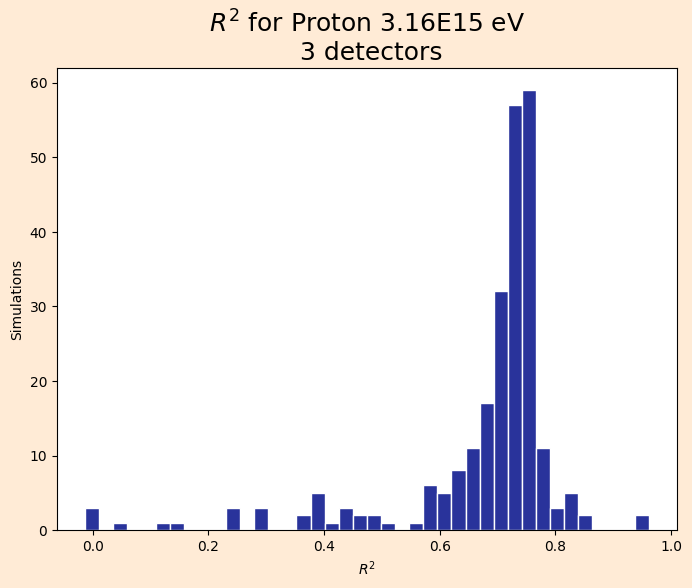

In [107]:
fig, ax = plt.subplots(figsize = (8, 6), facecolor = '#FFEBD6')
plt.hist(parameters_df['R_2'], color='#29339B', bins= 40, edgecolor = 'white')
plt.ylabel('Simulations')
plt.xlabel('$R^2$')
plt.title('$R^2$ for ' + str(name) + ' eV\n 3 detectors', size = 18)
#plt.grid(True)

plt.savefig('plots/' + name.split(' ')[0].lower() + '/rsquared_' + caminho_arquivo.split('/')[-1] + '_3det.pdf', bbox_inches = 'tight', dpi = 600)

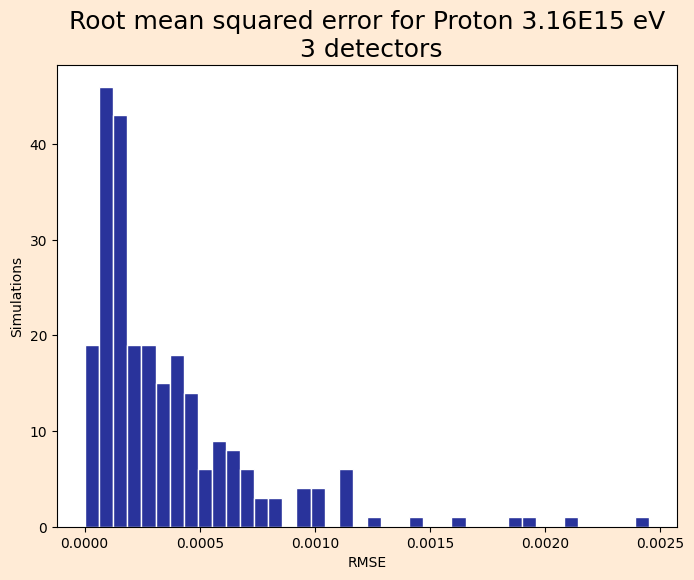

In [108]:
fig, ax = plt.subplots(figsize = (8, 6), facecolor = '#FFEBD6')
plt.hist(parameters_df['RMSE'], color='#29339B', bins= 40, edgecolor = 'white')
plt.ylabel('Simulations')
plt.xlabel('RMSE')
plt.title('Root mean squared error for ' + str(name) + ' eV\n 3 detectors', size = 18)
#plt.grid(True)

plt.savefig('plots/' + name.split(' ')[0].lower() + '/rmse_' + caminho_arquivo.split('/')[-1] + '_3det.pdf', bbox_inches = 'tight', dpi = 600)

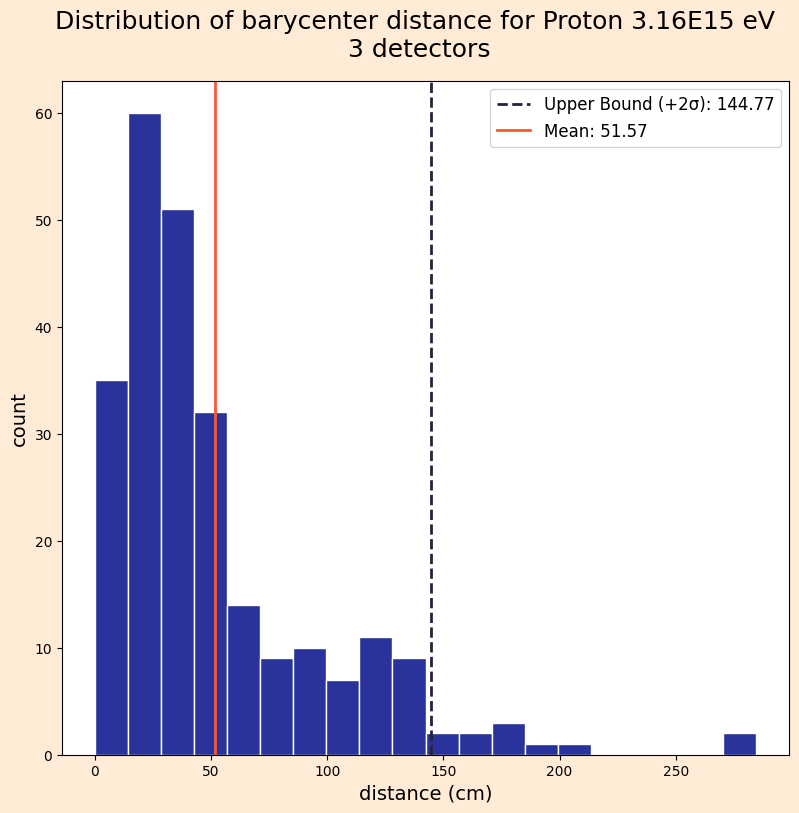

In [109]:
fig, ax = plt.subplots(1, 1, figsize = (8, 8), facecolor = '#FFEBD6')
fig.suptitle('Distribution of barycenter distance for ' + str(name) + ' eV\n 3 detectors', size = 18)
fig.tight_layout()

# Calcula a média e o desvio padrão dos dados
mean = df['r_b'].mean()
std = df['r_b'].std()

# Determina os limites de 2 sigma
#lower_bound = mean - 2 * std
upper_bound = mean + 2 * std

plt.hist(df['r_b'], color = '#29339B', edgecolor = 'white', bins = 20)

# Adiciona linhas verticais para os limites de 2 sigma
#ax.axvline(lower_bound, color='#548C2F', linestyle='--', linewidth=2, label=f'Lower Bound (-2σ): {lower_bound:.2f}')
ax.axvline(upper_bound, color='#27213C', linestyle='--', linewidth=2, label=f'Upper Bound (+2σ): {upper_bound:.2f}')
ax.axvline(mean, color='#F95738', linestyle='-', linewidth=2, label=f'Mean: {mean:.2f}')

# Personaliza o eixo e a legenda
ax.set_xlabel('distance (cm)', size=14)
ax.set_ylabel('count', size=14)
ax.legend(loc='upper right', fontsize=12)

plt.savefig('plots/' + name.split(' ')[0].lower() + '/barycenter_distribution_' + caminho_arquivo.split('/')[-1] + '_3det.pdf', bbox_inches = 'tight', dpi= 600)

C:\Users\Lucas\AppData\Local\Temp\ipykernel_11128\754703897.py:24: RuntimeWarning: invalid value encountered in log10
  return np.log10(k*x**p)
C:\Users\Lucas\AppData\Local\Temp\ipykernel_11128\754703897.py:38: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title = 'k = {:.2e} $\pm$ {:.2e}\np = {:.2f} $\pm$ {:.2f}'


[1.29082114e-08 1.02286966e-01]
[2.93312376 3.33870508 3.74479438 4.1503757 ]


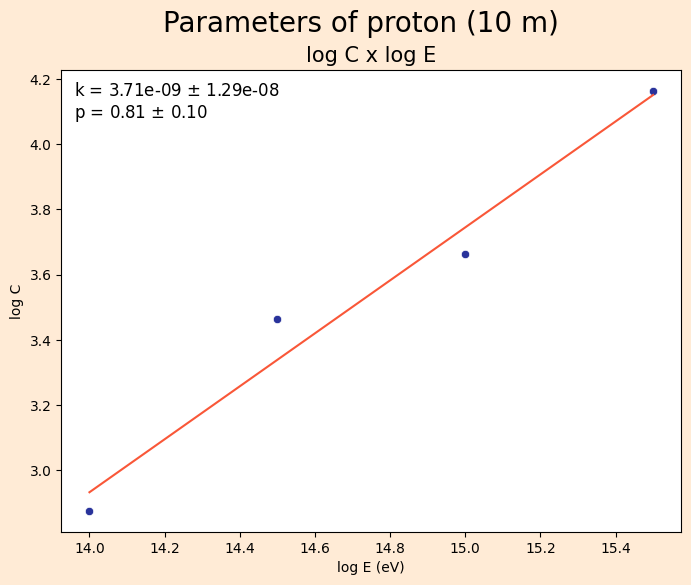

In [110]:
# Fit do próton
from scipy.optimize import curve_fit

C = [752.5, 2917, 4593, 1.457e+04]
E = [1E14, 3.16E14, 1E15, 3.16E15]

logC = np.log10(C)
logE = np.log10(E)


fig, ax = plt.subplots(figsize = (8, 6), facecolor = '#FFEBD6')
fig.suptitle('Parameters of proton (10 m)', size = 20)
#fig.tight_layout()


ax.set_title('log C x log E', size = 15)
ax.set_xlabel('log E (eV)')
ax.set_ylabel('log C')
ax.set_facecolor('white')


#Fit
def power(x, k, p):
    return np.log10(k*x**p)

initial_guess = [1,1]

coefficients_proton, cov = curve_fit(power, E, np.log10(C), p0=initial_guess)

inc = np.sqrt(np.diag(cov))
print(np.sqrt(np.diag(cov)))

print(power(E,*coefficients_proton))

ax.plot(logE, power(E,*coefficients_proton), color = '#F95738')
sns.scatterplot(x = logE, y = logC, color = '#29339B', ax = ax)

ax.legend(title = 'k = {:.2e} $\pm$ {:.2e}\np = {:.2f} $\pm$ {:.2f}'
          .format(coefficients_proton[0],inc[0],coefficients_proton[1],inc[1]),
          title_fontsize = 12,facecolor = 'white', frameon = False)


logE_0_array = ((np.log10(C/coefficients_proton[0]))/coefficients_proton[1])

logE_0 = logE_0_array.tolist()

data = {
    'logC':logC,
    'logE_S':logE,
    'logE_R':logE_0
}

df = pl.DataFrame(data)

df = df.with_columns(
        abs((((pl.col('logE_R')-pl.col('logE_S'))/pl.col('logE_S'))*100)).alias('error (%)')
)
df

plt.savefig('plots/' + name.split(' ')[0].lower() + '/parameter_c_' + name.split(' ')[0].lower() + '_3det.pdf', bbox_inches = 'tight', dpi= 600)

In [111]:
k_proton = coefficients_proton[0] 
p_proton = coefficients_proton[1] 
c_proton = parameters_df['C'] 
#c_photon = df['C_optimized']
E_proton = []
E_real = float(name.split(' ')[1])

erro_relativo = []
erro_absoluto = []

for i in range(len(c_proton)):
    E = (c_proton[i] / k_proton) ** (1 / p_proton)
    E_proton.append(E)
    
    # Calcular erro absoluto
    erro_abs = abs(E - E_real)
    erro_absoluto.append(erro_abs)
    
    # Calcular erro relativo (em porcentagem)
    erro_rel = (erro_abs / E_real) * 100
    erro_relativo.append(erro_rel)

data = {
    'E':E_proton,
    'Relative_error':erro_relativo,
    'Absolute_error':erro_absoluto
}

df3 = pl.DataFrame(data)
df3

E,Relative_error,Absolute_error
f64,f64,f64
1.7835e15,43.559275,1.3765e15
2.8084e15,11.125394,3.5156e14
2.6001e16,722.828172,2.2841e16
9.2303e16,2820.989113,8.9143e16
2.1805e16,590.027238,1.8645e16
…,…,…
6.6062e16,1990.555439,6.2902e16
2.9153e15,7.742243,2.4465e14
8.0571e14,74.503001,2.3543e15


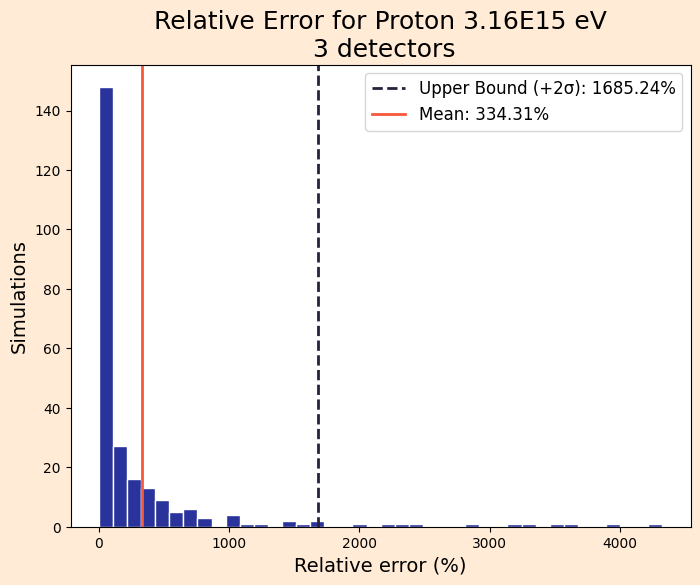

In [112]:
fig, ax = plt.subplots(figsize = (8, 6), facecolor = '#FFEBD6')
plt.hist(erro_relativo, color='#29339B', bins= 40, edgecolor = 'white')
plt.ylabel('Simulations')
plt.xlabel('Relative Error (%)')
plt.title('Relative Error for ' + str(name) + ' eV\n 3 detectors', size = 18)
#plt.grid(True)

# Calcula a média e o desvio padrão dos dados
mean = df3['Relative_error'].mean()
std = df3['Relative_error'].std()

# Determina os limites de 2 sigma
#lower_bound = mean - 2 * std
upper_bound = mean + 2 * std


# Adiciona linhas verticais para os limites de 2 sigma
#ax.axvline(lower_bound, color='#548C2F', linestyle='--', linewidth=2, label=f'Lower Bound (-2σ): {lower_bound:.2f}')
ax.axvline(upper_bound, color='#27213C', linestyle='--', linewidth=2, label=f'Upper Bound (+2σ): {upper_bound:.2f}%')
ax.axvline(mean, color='#F95738', linestyle='-', linewidth=2, label=f'Mean: {mean:.2f}%')

# Personaliza o eixo e a legenda
ax.set_xlabel('Relative error (%)', size=14)
ax.set_ylabel('Simulations', size=14)
ax.legend(loc='upper right', fontsize=12)

plt.savefig('plots/' + name.split(' ')[0].lower() +'/energy_'+ caminho_arquivo.split('/')[-1] + '_3det.pdf',bbox_inches = 'tight', dpi = 600)

In [113]:
from uncertainties import ufloat
import uncertainties.umath as umath

k_value = coefficients_proton[0]
k_error = inc[0]  
p_value = coefficients_proton[1]
p_error = inc[1]  

k_proton = ufloat(k_value, k_error)
p_proton = ufloat(p_value, p_error)

c_protons = [ufloat(c, c_err) for c, c_err in zip(parameters_df['C'], parameters_df['C_err'])]

E_photon_with_errors = []

E_real = float(name.split(' ')[1])

for c in c_protons:
    E = (c / k_proton) ** (1 / p_proton)
    E_photon_with_errors.append(E)


E_nominal = [e.nominal_value for e in E_photon_with_errors]
E_error = [e.std_dev for e in E_photon_with_errors]

erro_absoluto = [abs(e.nominal_value - E_real) for e in E_photon_with_errors]
erro_relativo = [(erro / E_real) * 100 for erro in erro_absoluto]


data = {
    'E': E_nominal,
    'Propagated_uncertainty': E_error,
    'Absolute_error': erro_absoluto,
    'Relative_error': erro_relativo    
}

df3 = pl.DataFrame(data)

df3

E,Propagated_uncertainty,Absolute_error,Relative_error
f64,f64,f64,f64
1.7835e15,1.4848e16,1.3765e15,43.559275
2.8084e15,2.0448e16,3.5156e14,11.125394
2.6001e16,1.8732e17,2.2841e16,722.828172
9.2303e16,6.7014e17,8.9143e16,2820.989113
2.1805e16,1.5797e17,1.8645e16,590.027238
…,…,…,…
6.6062e16,4.8546e17,6.2902e16,1990.555439
2.9153e15,1.9495e16,2.4465e14,7.742243
8.0571e14,6.7724e15,2.3543e15,74.503001


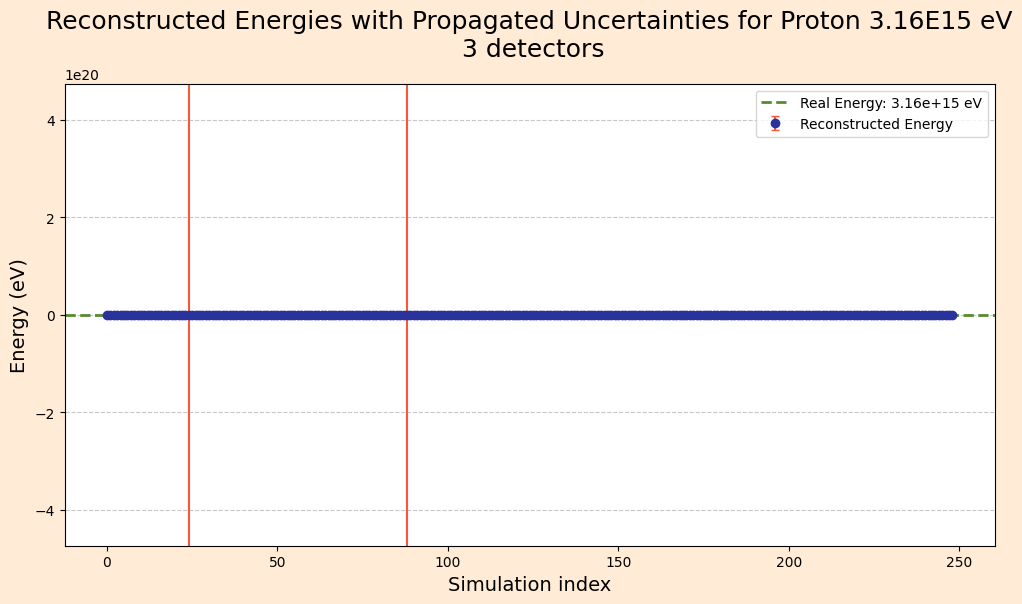

In [114]:
x = np.arange(len(E_nominal))  

plt.figure(figsize=(12, 6), facecolor='#FFEBD6')
ax = plt.gca()

plt.errorbar(
    x,
    E_nominal,
    yerr=E_error,
    fmt='o',           
    color='#29339B',    
    ecolor='#F95738',   
    elinewidth=1.5,    
    capsize=3,          
    #alpha=0.7,          
    label='Reconstructed Energy'
)

plt.axhline(
    E_real,
    color='#548C2F',
    linestyle='--',
    linewidth=2,
    label=f'Real Energy: {E_real:.2e} eV'
)

plt.xlabel('Simulation index', size=14)
plt.ylabel('Energy (eV)', size=14)
plt.title('Reconstructed Energies with Propagated Uncertainties for ' + str(name) + ' eV\n 3 detectors', size=18, pad=20)

# Adicionar legenda e grid
plt.legend(loc='upper right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.ylim(
    min(E_nominal) - 3 * np.mean(E_error),
    max(E_nominal) + 3 * np.mean(E_error)
)


plt.savefig('plots/' + name.split(' ')[0].lower() +'/energy_error_'+ caminho_arquivo.split('/')[-1] + '_3det.pdf',bbox_inches = 'tight', dpi = 600)

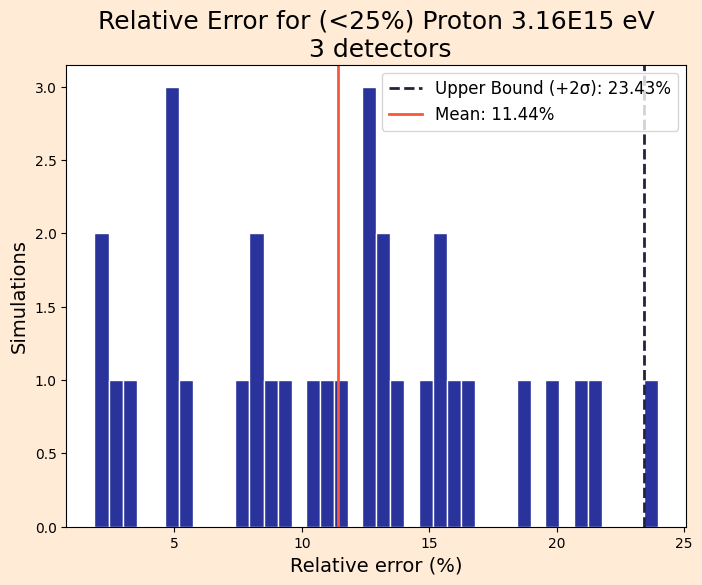

In [115]:
df3 = df3.filter(pl.col("Relative_error") < 25)

fig, ax = plt.subplots(figsize = (8, 6), facecolor = '#FFEBD6')
plt.hist(df3['Relative_error'], color='#29339B', bins= 40, edgecolor = 'white')
plt.ylabel('Simulations')
plt.xlabel('Relative Error (%)')
plt.title('Relative Error for (<25%) ' + str(name) + ' eV\n 3 detectors', size = 18)
#plt.grid(True)

# Calcula a média e o desvio padrão dos dados
mean = df3['Relative_error'].mean()
std = df3['Relative_error'].std()

# Determina os limites de 2 sigma
#lower_bound = mean - 2 * std
upper_bound = mean + 2 * std


# Adiciona linhas verticais para os limites de 2 sigma
#ax.axvline(lower_bound, color='#548C2F', linestyle='--', linewidth=2, label=f'Lower Bound (-2σ): {lower_bound:.2f}')
ax.axvline(upper_bound, color='#27213C', linestyle='--', linewidth=2, label=f'Upper Bound (+2σ): {upper_bound:.2f}%')
ax.axvline(mean, color='#F95738', linestyle='-', linewidth=2, label=f'Mean: {mean:.2f}%')

# Personaliza o eixo e a legenda
ax.set_xlabel('Relative error (%)', size=14)
ax.set_ylabel('Simulations', size=14)
ax.legend(loc='upper right', fontsize=12)

plt.savefig('plots/' + name.split(' ')[0].lower() +'/energy_25_'+ caminho_arquivo.split('/')[-1] + '_3det.pdf',bbox_inches = 'tight', dpi = 600)

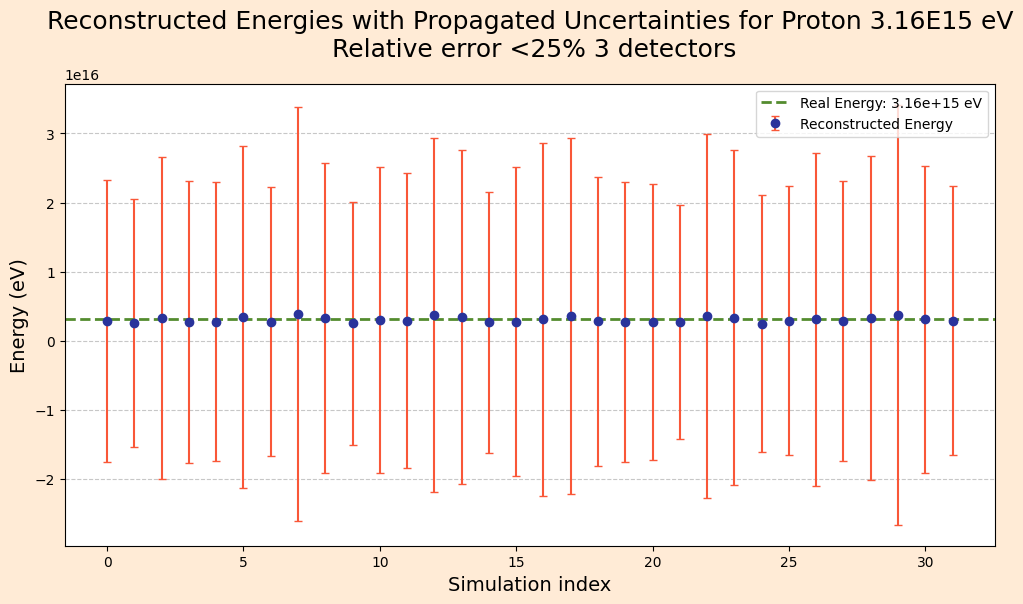

: 

In [ ]:
x = np.arange(len(df3))  

plt.figure(figsize=(12, 6), facecolor='#FFEBD6')
ax = plt.gca()

plt.errorbar(
    x,
    df3['E'],
    yerr=df3['Propagated_uncertainty'],
    fmt='o',           
    color='#29339B',    
    ecolor='#F95738',   
    elinewidth=1.5,    
    capsize=3,          
    #alpha=0.7,          
    label='Reconstructed Energy'
)

plt.axhline(
    E_real,
    color='#548C2F',
    linestyle='--',
    linewidth=2,
    label=f'Real Energy: {E_real:.2e} eV'
)

plt.xlabel('Simulation index', size=14)
plt.ylabel('Energy (eV)', size=14)
plt.title('Reconstructed Energies with Propagated Uncertainties for ' + str(name) + ' eV\n Relative error <25% 3 detectors', size=18, pad=20)

# Adicionar legenda e grid
plt.legend(loc='upper right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

#plt.ylim(
#    min(E_nominal) - 3 * np.mean(E_error),
#    max(E_nominal) + 3 * np.mean(E_error)
#)


plt.savefig('plots/' + name.split(' ')[0].lower() +'/energy_error_25_'+ caminho_arquivo.split('/')[-1] + '_3det.pdf',bbox_inches = 'tight', dpi = 600)